In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [13]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')

### CNN training

In [14]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 44, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 32)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 22, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                45120     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

### LSTM training

In [16]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2486/248

### AE-LSTM

In [17]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 46, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65  

2025-06-20 12:13:53.587810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


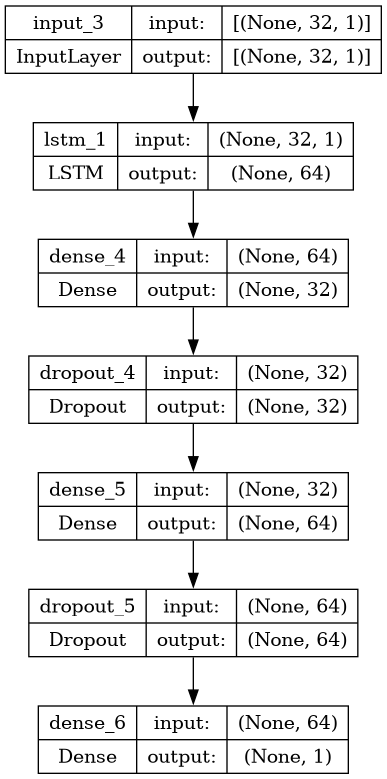

In [1]:
from tensorflow.keras.utils import plot_model
import pydot

from tensorflow.keras.models import load_model

cnn_loaded = load_model('../../models/cnn_ciciot_model.keras')
lstm_loaded = load_model('../../models/lstm_ciciot_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_ciciot_model.keras')

plot_model(cnn_loaded, to_file='../../results/CICIOT_updated/CNN_model.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_loaded, to_file='../../results/CICIOT_updated/LSTM_model.png', show_shapes=True, show_layer_names=True)
plot_model(ae_lstm_loaded, to_file='../../results/CICIOT_updated/AE-LSTM_model.png', show_shapes=True, show_layer_names=True)

Let's save our models

In [18]:
CNN_model.save("../../models/cnn_ciciot_updated_model.keras")

In [19]:
LSTM_model.save("../../models/lstm_ciciot_updated_model.keras")

In [20]:
AE_LSTM_model.save("../../models/ae-lstm_ciciot_updated_model.keras")

### CNN metrics

2131/2131 [==============================] - 1s 483us/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     34081
     Attacks       1.00      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.99      0.98      0.98     68162
weighted avg       0.99      0.98      0.98     68162

Test Loss: 0.0553
Test Accuracy: 0.9848


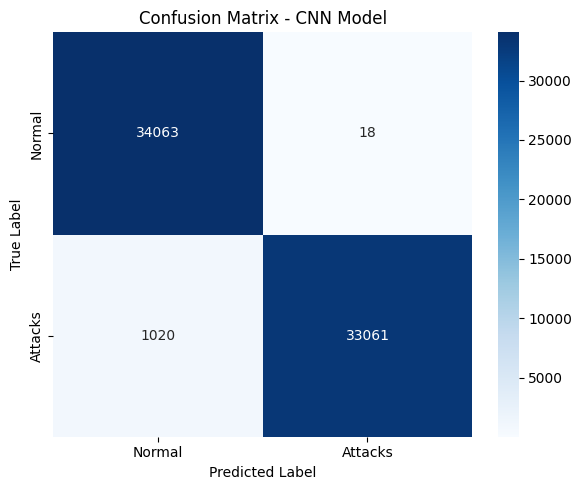

Attacks detected (True Positive) : 33061
Normal traffic detected (True Negative) : 34063
Attacks missed (False Negative) : 1020
False alarms (False Positive) : 18


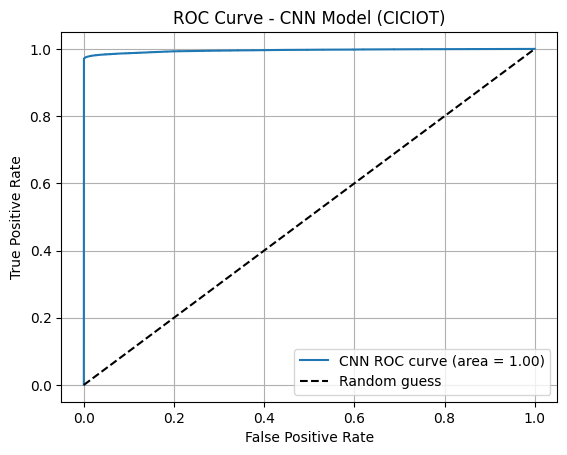

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### LSTM metrics

2131/2131 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     34081
     Attacks       1.00      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0553
Test Accuracy: 0.9848


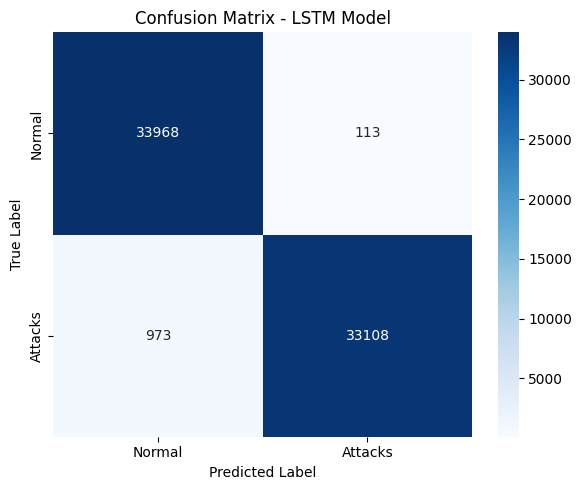

Attacks detected (True Positive) : 33108
Normal traffic detected (True Negative) : 33968
Attacks missed (False Negative) : 973
False alarms (False Positive) : 113


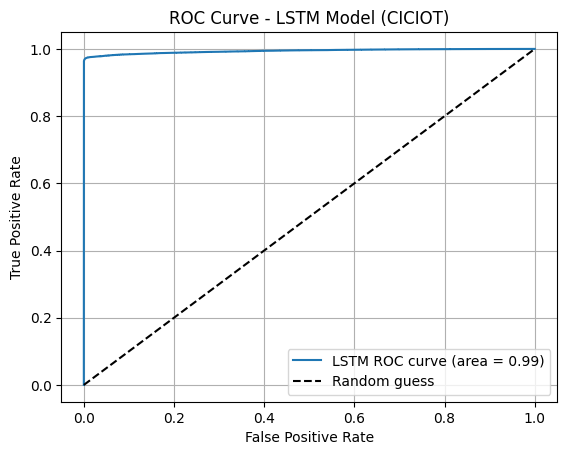

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### AE-LSTM metrics

2131/2131 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     34081
     Attacks       0.99      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0553
Test Accuracy: 0.9848


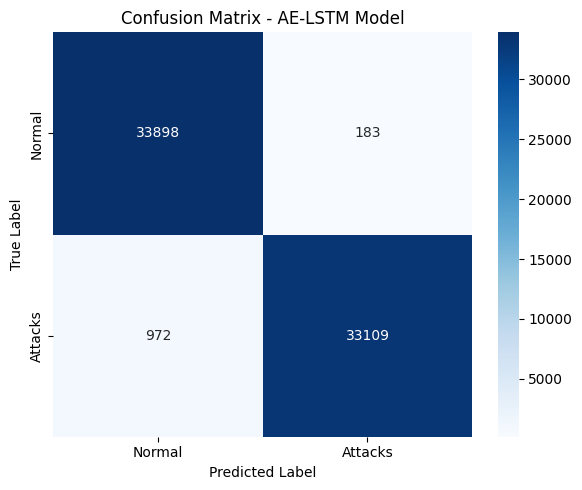

Attacks detected (True Positive) : 33109
Normal traffic detected (True Negative) : 33898
Attacks missed (False Negative) : 972
False alarms (False Positive) : 183


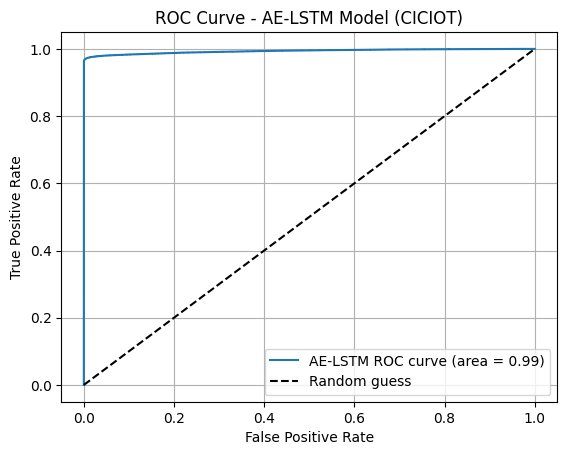

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()